## Part 1

CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the
movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision
and multimedia experts who need to detect faces from screen shots from the movie scene.


• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.


• PROJECT OBJECTIVE: Face detection from training images

###Loading the Dataset


In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/CV')

### Import Packages

In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2
import sys
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

###Checking train directories to load dataset files : 

In [4]:
!ls

'Part 1- Train data - images.npy'


In [20]:
#Setting to default values and recursion level to avoid runtime errors

np.load.__defaults__=(None, True, True, 'ASCII')
sys.setrecursionlimit(15000)

In [6]:
np_load_old = np.load

# modify the default parameters of np.load
#np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

#np.load(path, allow_pickle=True)

np.load = lambda *a,**k: np_load_old(*a,allow_pickle=True)


data = np.load('Part 1- Train data - images.npy', allow_pickle=True)

### Lets check one sample from loaded dataset :

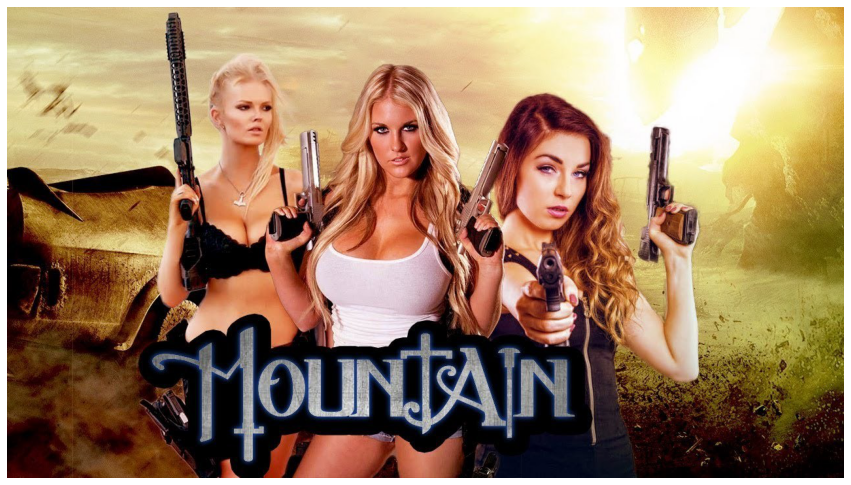

In [12]:
fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[100][0])
plt.show()

### Now we will resize image : width = height = 224, alpha = 1

In [13]:
ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Now we will create features and labels : 

In our case : 
feature is image, label will be mask, Images will be stored in 'X' array and masks will be stored in 'masks' array

In [14]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array

In [15]:
X.shape

(409, 224, 224, 3)

In [16]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


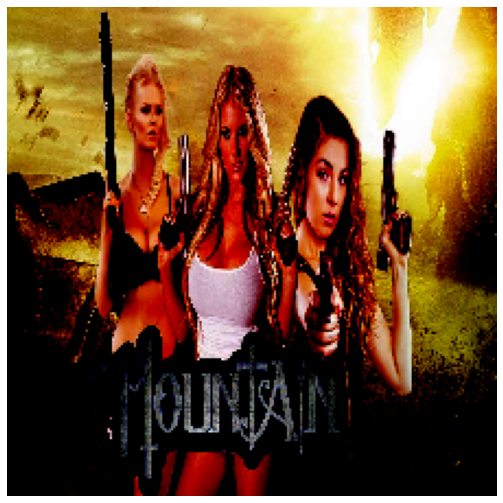

In [17]:
n = 100
fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

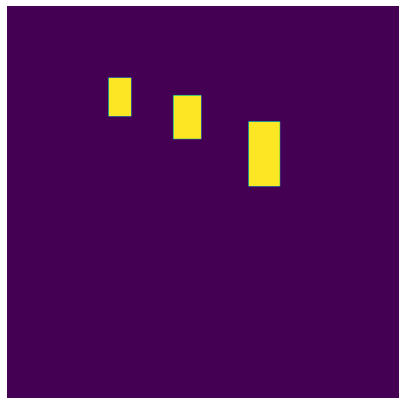

In [19]:
n = 100
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(masks[n])

###Let's create the model
We will use MobileNet as model with parameter values :

input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
include_top: False
alpha: 1.0
weights: 'imagenet'

We will also use UNET and will be adding UNET architecture layers.

In [22]:
def convulution_block(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = convulution_block(up1, 256, 'Conv_6_1')
    conv6 = convulution_block(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = convulution_block(up2, 256, 'Conv_7_1')
    conv7 = convulution_block(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = convulution_block(up3, 192, 'Conv_8_1')
    conv8 = convulution_block(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = convulution_block(up4, 96, 'Conv_9_1')
    conv9 = convulution_block(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = convulution_block(up5, 48, 'Conv_10_1')
    conv10 = convulution_block(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

In [23]:
#Calling create_model() 

model = create_model(True)
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________

### Defining Dice Coefficient function :


In [24]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Defining Loss :

In [25]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

Now we will complie the model using parameters as follows :

loss: use the loss function defined above

optimizers: use Adam optimizer

metrics: use dice_coefficient function defined above

In [26]:
adam = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

### Defining Checkpoint  and EarlyStopping :

Early Stopping monitors the performance of the model for every epoch on a held-out validation set during the training, and terminate the training conditional on the validation performance thereby combatting overfitting issue as well. 

As the epochs go by, the algorithm leans and its error on the training set naturally goes down, and so does its error on the validation set. However, after a while, the validation error stops decreasing and actually starts to go back up. This indicates that the model has started to overfit the training data. With Early Stopping, you just stop training as soon as the validation error reaches the minimum.


In [27]:
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', period = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

### Fit the model

batch_size: 1

callbacks: checkpoint, reduce_lr, stop

We will split train and test data in ratio of 70 : 30 respectively.

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, masks, test_size = 0.30, random_state = 2019, shuffle = False)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((286, 224, 224, 3), (123, 224, 224, 3), (286, 224, 224), (123, 224, 224))

In [33]:
model.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))

Epoch 1/30
286/286 [==============================] - 11s 40ms/step - loss: 0.0862 - dice_coefficient: 0.9768 - val_loss: 1.1210 - val_dice_coefficient: 0.6558

Epoch 00001: loss did not improve from 0.08080
Epoch 2/30
286/286 [==============================] - 12s 40ms/step - loss: 0.0719 - dice_coefficient: 0.9856 - val_loss: 1.1276 - val_dice_coefficient: 0.6565

Epoch 00002: loss improved from 0.08080 to 0.07194, saving model to model_0.07.h5
Epoch 3/30
286/286 [==============================] - 11s 40ms/step - loss: 0.0668 - dice_coefficient: 0.9890 - val_loss: 1.1353 - val_dice_coefficient: 0.6594

Epoch 00003: loss improved from 0.07194 to 0.06680, saving model to model_0.07.h5
Epoch 4/30
286/286 [==============================] - 11s 40ms/step - loss: 0.0634 - dice_coefficient: 0.9915 - val_loss: 1.1664 - val_dice_coefficient: 0.6578

Epoch 00004: loss improved from 0.06680 to 0.06339, saving model to model_0.06.h5
Epoch 5/30
286/286 [==============================] - 11s 40ms/

We see that due to earlystopping, when loss consistently did not improve after many epochs, the model terminated. This saves our computational resources and also prevents overfitting of the model.

In [34]:
model.evaluate(X_valid, y_valid, verbose = 1)

4/4 [==============================] - 4s 1s/step - loss: 0.8607 - dice_coefficient: 0.6846


[0.86069655418396, 0.6846415996551514]

### Now we will get the predicted mask for a sample image :

In [35]:
# Load previous model weight
WEIGHTS_FILE = "model_0.11.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_valid, verbose = 1)

4/4 [==============================] - 1s 229ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


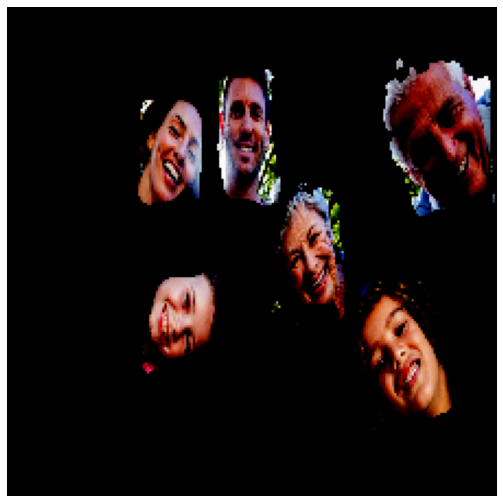

In [56]:
# For a sample image
n = 70
image = cv2.resize(X_valid[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

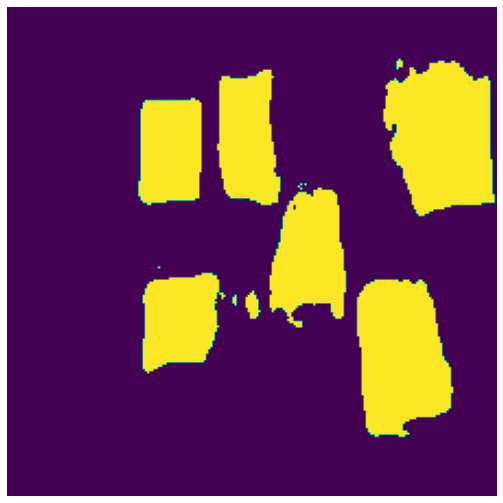

In [57]:
fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

### Impose the mask on the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


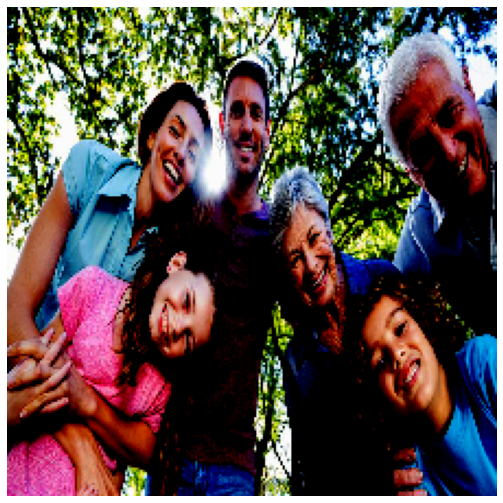

In [58]:
fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_valid[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

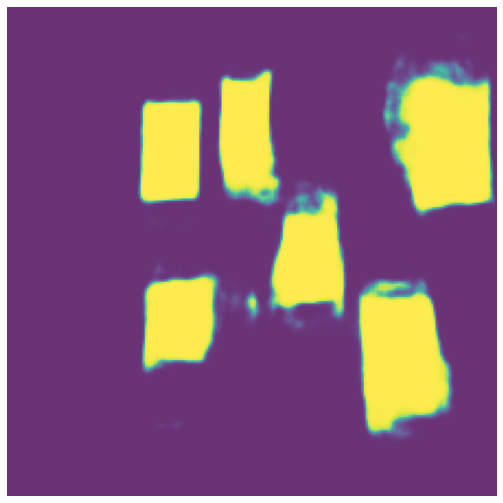

In [59]:
fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

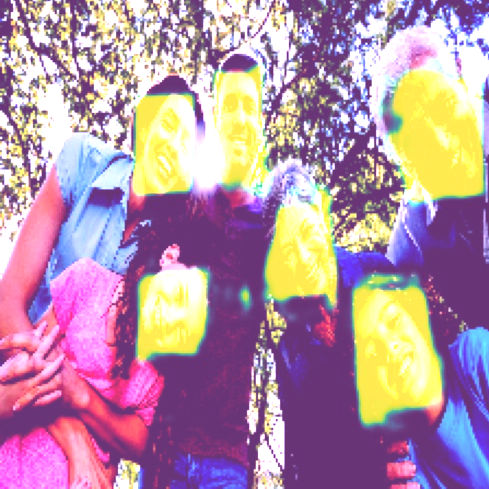

In [60]:
from google.colab.patches import cv2_imshow
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
cv2_imshow(img)

### Conclusion

The project revolved around performing face recognition, primarily designed for OTT platforms, where face of the cast actors/actress can be recognised. We can see the same in Amazon Prime, when we pause a movie or series, we see the details of the actors/actress present in the current frame.

Here, we have made use of a pretrained MobileNet (Transfer Learning) and on top of it have added UNET layers to train, fit and evaluate model. The objective of the model is to predict the boundaries (masks in our case) around the face in a given image.


We also had incorporated binary cross entropy as loss, adam optimizer and dice coefficient as performance metrics.

We have our metrics as :

loss: 0.8607 - dice_coefficient: 0.6846


Model weights were used and then used to predict on validation data to get mask. Post which we checked sample image and imposed mask on the image.

Overall, we could see a substantial overlap seen in the above images and masks, therefore we can say that our model performs reasonably good in predicting the masks.

------------------------------------------------------------X------------------------------------------------------------------------------------------------X-------------------------------------------------------------------

## Part 2


CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer
vision and multimedia experts who need to detect faces from screen shots from the movie scene.

In [1]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 7.5MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Extracting Zip file :

In [4]:
import zipfile
data_dir ='/content/drive/MyDrive/CV/Part2/Part 2 - training images.zip'
archive = zipfile.ZipFile(data_dir, 'r')
archive.extractall()

In [7]:
# extracting and plotting each detected face in a photograph 

from matplotlib import pyplot
from matplotlib import patches
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN
import math as mt
import pandas as pd
import os as os

### Function for extracting faces :

In [6]:
def extract_faces(df):
  #We will be using MTCNN
  detector = MTCNN()
  data_dir='/content/training_images'
  images_list = []
  image_files = os.listdir( data_dir ) 
  num_folders = len(image_files)
  print(image_files)
  count=0
  for i in image_files:
    data = pyplot.imread(data_dir +'/'+ i)
    faces = detector.detect_faces(data)
    df1=pd.DataFrame(columns=['x','y','w','h','total_faces','Image_names'])

    # plotting each face as a subplot
    for j in range(len(faces)):
      x1, y1, width, height = faces[j]['box']
      df.loc[count]=[abs(x1),abs(y1), abs(width), abs(height),len(faces),i]
      count=count+1
  print(df)

In [9]:
#calling extract_faces
df = pd.DataFrame(columns=['x','y','w','h','total_faces','Image_names'])

extract_faces(df)

['real_00806.jpg', 'real_00714.jpg', 'real_00462.jpg', 'real_00009.jpg', 'real_00215.jpg', 'real_00592.jpg', 'real_00494(1).jpg', 'real_00960.jpg', 'real_00469.jpg', 'real_00398.jpg', 'real_00102.jpg', 'real_00836.jpg', 'real_00553.jpg', 'real_01025.jpg', 'real_00422.jpg', 'real_01041.jpg', 'real_00631.jpg', 'real_00401.jpg', 'real_00204.jpg', 'real_00678.jpg', 'real_00198.jpg', 'real_00287.jpg', 'real_00662.jpg', 'real_00305.jpg', 'real_00886.jpg', 'real_00931.jpg', 'real_00495(1).jpg', 'real_00481(1).jpg', 'real_00945.jpg', 'real_00190.jpg', 'real_00708.jpg', 'real_00264.jpg', 'real_00965.jpg', 'real_00820.jpg', 'real_00199.jpg', 'real_00022.jpg', 'real_00500.jpg', 'real_00315.jpg', 'real_00712.jpg', 'real_00558.jpg', 'real_00875.jpg', 'real_00019.jpg', 'real_00435.jpg', 'real_00655.jpg', 'real_00811.jpg', 'real_00760.jpg', 'real_00510.jpg', 'real_00361.jpg', 'real_00052.jpg', 'real_00684.jpg', 'real_00583.jpg', 'real_00969.jpg', 'real_00122.jpg', 'real_00217.jpg', 'real_00618.jpg', 

In [10]:
print(df.head())

     x    y    w    h total_faces     Image_names
0  133  156  306  414           1  real_00806.jpg
1  101  125  352  424           1  real_00714.jpg
2  111  166  328  421           1  real_00462.jpg
3  146   22  365  569           1  real_00009.jpg
4  106  148  350  432           1  real_00215.jpg


### Function to draw each face seperately : 

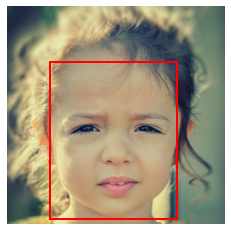

[{'box': [118, 152, 349, 433], 'confidence': 0.9999525547027588, 'keypoints': {'left_eye': (221, 332), 'right_eye': (379, 335), 'nose': (307, 420), 'mouth_left': (239, 490), 'mouth_right': (361, 489)}}]


In [13]:
# Now we will draw each face separately
def draw_faces(filename, result_list):
  # load the image
  data = pyplot.imread(filename)
  for i in range(len(result_list)):
    # get coordinates
    x1, y1, width, height = result_list[i]['box']
    x2, y2 = x1 + width, y1 + height
    # define subplot
    fig,ax = pyplot.subplots(1)
    ax.axis('off')
    # plot face
    ax.imshow(data) #[abs(y1):abs(y2), abs(x1):abs(x2)]
    rect=patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
  # show the plot
  pyplot.show()
 
filename = '/content/training_images/real_00355.jpg'
# load image from file
pixels = pyplot.imread(filename)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_faces(filename, faces)
print(faces)

###Conclusion :

We can see that using MTCNN, we have created Bounding Boxes with our co-ordinates i.e Annotations for our images. In the Media/OTT platform, whenever an user pauses,we can use this algorithm to create bounded boxes with co-ordinates, to view detais of the actor/actress in that frame/scene.

We aso see that, our MTCNN model reasonably performs well with relevant bounded boxes and reasonably accurate co-ordinates for the annotations.

------------------------------------------------------------X------------------------------------------------------------------------------------------------X-------------------------------------------------------------------

## Part 3

CONTEXT: Company X intends to build a face identification model to recognise human faces.

• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. 

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/CV/Face_Detection')

### Import necessary libraries :

In [ ]:
%tensorflow_version 2.x

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline
from zipfile import ZipFile
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
random_state = 2020
import warnings; warnings.filterwarnings('ignore')


### Extract zip file to access dataset :

In [ ]:
!ls

'Part 3 - Aligned Face Dataset from Pinterest.zip'
'Part 3 - vgg_face_weights.h5'


In [ ]:
with ZipFile('Part 3 - Aligned Face Dataset from Pinterest.zip', 'r') as zip:
  zip.extractall()

### Function to load images : 
We will define a function to load the images from the extracted folder and map each image its person id 


In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allowing only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

### Defining function to load image :

In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

Let's load a sample image :

In [ ]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

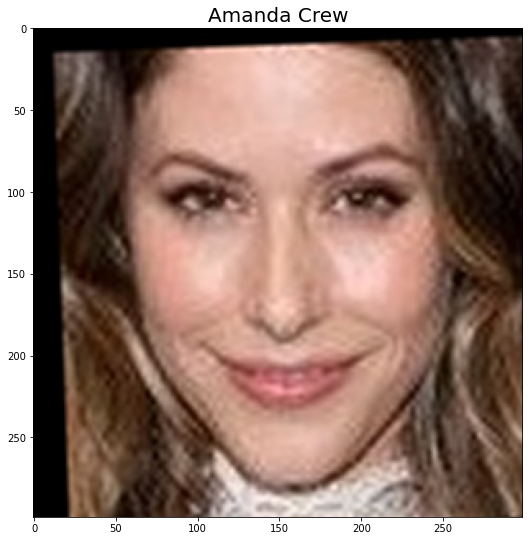

In [ ]:
fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

### Defining VGG Face Model : 

In [ ]:
def vgg_face_model():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

### Now let's load the model and also weight file named 'Part 3 - vgg_face_weights.h5':

In [ ]:
model = vgg_face_model()
model.load_weights('Part 3 - vgg_face_weights.h5')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_13 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 128)    

### Let's define vgg_face_descriptor :

In [ ]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

### Generate embeddings for each image in the dataset :

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images :

We will iterate through metadata and create embeddings for each image using 'vgg_face_descriptor.predict()' and store in a list named 'embeddings'

If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes, since the final embedding from the model is of length 2622.

In [ ]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

### Now let's calculate Eucledian distance between given 2 pairs of images :


In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 5, 6 and 5, 120
- 32, 33 and 32, 100
- 55, 56 and 55, 89

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

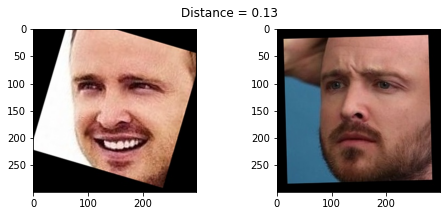

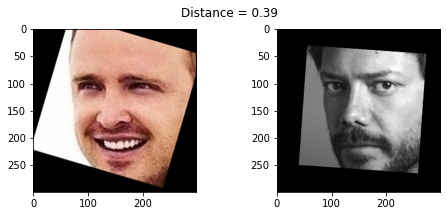

In [ ]:
show_pair(5, 6)
show_pair(5, 120)

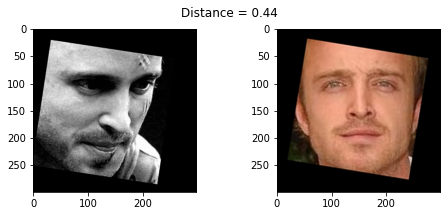

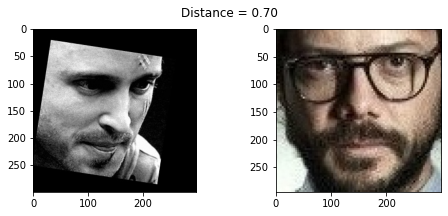

In [ ]:
show_pair(32, 33)
show_pair(32, 100)

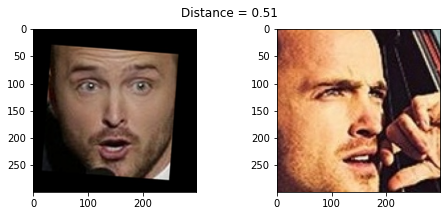

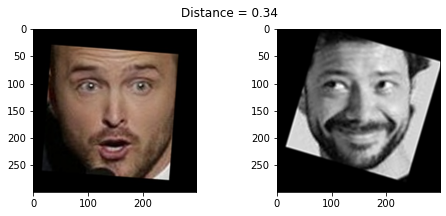

In [ ]:
show_pair(55, 56)
show_pair(55, 89)

### Split dataset into train and test sets
Creating X_train, X_test and y_train, y_test

We have train_idx to seperate out training features and labels

We have test_idx to seperate out testing features and labels

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

### Encoding the Labels (using LabelEncoder) :

In [ ]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

### Standardize the feature values (using StandardScaler) :

In [ ]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Dimensionality Reduction using PCA :

We will reduce feature dimensions using Principal Component Analysis (PCA)

In [ ]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58890703  18.98690264  22.97728235 ...  99.99999983  99.99999999
 100.        ]


In [ ]:
# Getting index where cumulative variance explained is greater than threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres} is : {str(index)}')

Index of element just greater than 95 is : 347


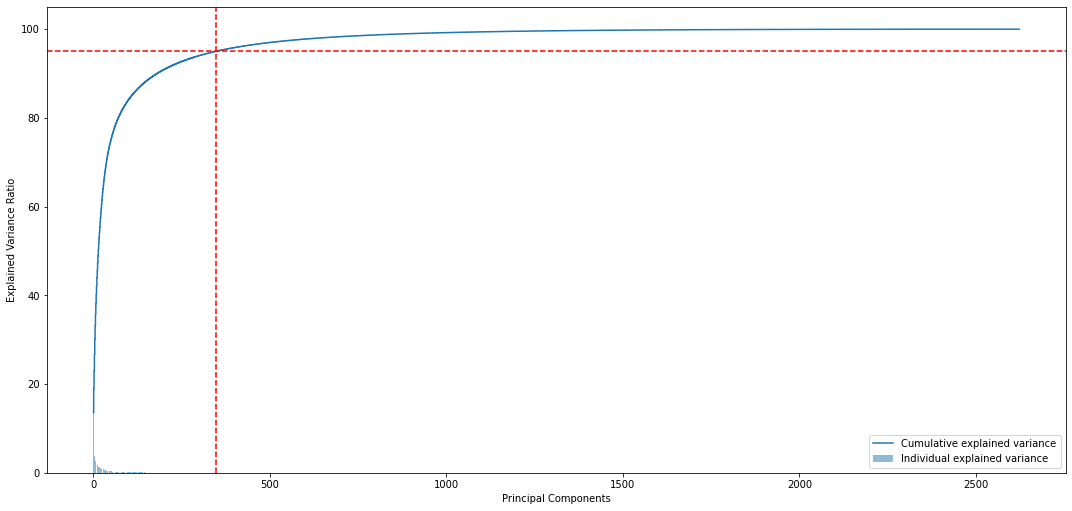

In [ ]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [ ]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 347)

(1197, 347)

### Building a Classifier : 

We will use SVM Classifier to predict the person in the given image and fit it to calculate score.

In [ ]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.995


In [ ]:
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.965


In [ ]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        13
Alycia Debnam Carey Face       1.00      0.92      0.96        13
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      1.00      1.00         9
        Amber Heard Face       1.00      1.00      1.00         8
               Anna Gunn       0.88      1.00      0.93        14
           Anne Hathaway       0.93      0.93      0.93        14
     Barbara Palvin Face       1.00      0.89      0.94         9
      Bellamy Blake Face       0.93      1.00      0.96        13
    Benedict Cumberbatch       0.93      1.00      0.96        13
            Betsy Brandt       1.00      1.00      1.00         9
              Bill Gates       0.91      1.00      

### Test results

Let's take maybe 50th image from test set and plot the image and map to which person(folder name in dataset) that image belongs.

In [ ]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

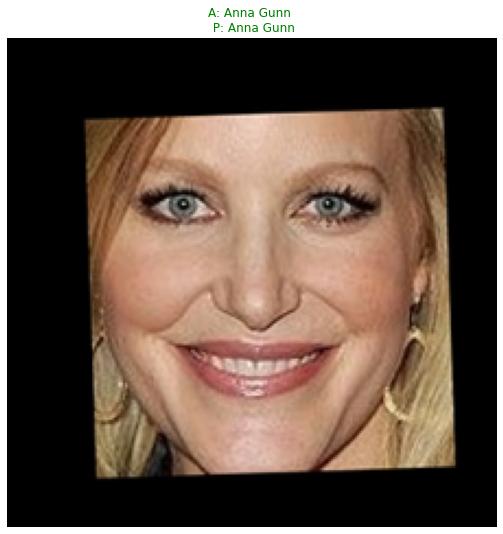

In [ ]:
# Plot for 50th image in test data
sample_img, actual_name, pred_name = sample_img_plot(50)
fig = plt.figure(figsize = (15, 9))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

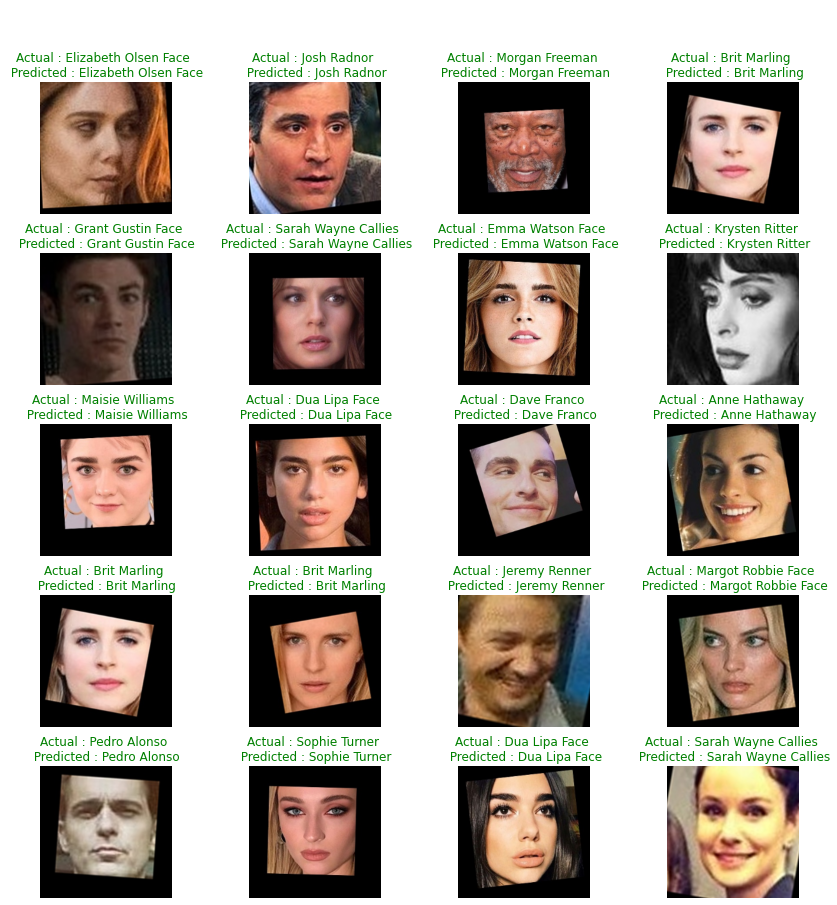

In [ ]:
# Now let's try with random 20 sample images from test data
plt.figure(figsize = (15, 15))
gs1 = gridspec.GridSpec(5, 4)
gs1.update(wspace = 0, hspace = 0.3) 

for i in range(20):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))
  
    plt.axis('off')
    plt.imshow(sample_img)
  
    plt.title(f"\n\n\nActual : {actual_name} \n Predicted : {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

### Conclusion :

We have been invloved to recognize aligned faces from a dataset containing 10000+ images for 100 people using a pre-trained model on Face Recognition.

Firstly, we used VGG model with pre-trained weights was used to generate embeddings for each images in our dataset.

Then, we calculated Eucledian Distance between two pair of images and  also plotted them.

Since, there were 2,622 features for each image, PCA was used for dimension reduction after standardizing the features using StndardScaler.We got a cumulative explained variance of 95%, and 347 PCA components were used.

Using SVC we predicted the labels for test dataset with an accuracy of more than 96% which seems to be a resonably very good accuracy.

Finally, comparing predicted and actual labels for a given sample image as well as for 20 random images from test dataset, we see that our model performs well in face recognition.

------------------------------------------------------------X------------------------------------------------------------------------------------------------X-------------------------------------------------------------------

## Part 4

DOMAIN: State traffic department

• CONTEXT: City X’s traffic department wants to understand the traffic density on road during busy hours in order to efficiently program their traffic lights.

• TASK: Create an automation using computer vision to impute dynamic bounding boxes to locate cars or vehicles on the road. It would
require for you to do some research on how to impute bounding boxes on video file. You can use video provided with this assignment or
any video of your choice which has moving cars to impute bounding boxes.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

# Building Model :

The model architecture consists of 9 convolutional layers, followed by 3 fully connected layers. Each convolutional layer is followed by a Leaky RELU activation function, with alpha of 0.1. The first 6 convolutional layers also have a 2x2 max pooling layers.

In [ ]:
#keras.backend.set_image_dim_ordering('th')

def get_model():
    model = Sequential()
    
    # Layer 1
    model.add(Convolution2D(16, (3, 3),input_shape=(3, 448,448),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    # Layer 2
    model.add(Convolution2D(32,(3,3) ,padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    # Layer 3
    model.add(Convolution2D(64,(3,3) ,padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    
    # Layer 4
    model.add(Convolution2D(128,(3,3) ,padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    # Layer 5
    model.add(Convolution2D(256, (3,3) ,padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    # Layer 6
    model.add(Convolution2D(512, (3,3) ,padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    # Layer 7
    model.add(Convolution2D(1024, (3,3) ,padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 8
    model.add(Convolution2D(1024, (3,3) ,padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 9
    model.add(Convolution2D(1024, (3,3) ,padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Flatten())
    
    # Layer 10
    model.add(Dense(256))
    
    # Layer 11
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 12
    model.add(Dense(1470))
    
    return model

## Pre-processing

We first determine the area of interest for each image. We only consider this portion of the image for prediction, since cars won't be present all over the image, just on the roads in the lower portion of the image. Then this cropped image is resized to a 448x448 image.

Normalization :

Each image pixel is normalized to have values between -1 and 1. We use simple min-max normalization to achieve this.

In [ ]:
# Preprocessing

def crop_and_resize(image):
    cropped = image[300:650,500:,:]
    return cv2.resize(cropped, (448,448))

def normalize(image):
    normalized = 2.0*image/255.0 - 1
    return normalized

def preprocess(image):
    cropped = crop_and_resize(image)
    normalized = normalize(cropped)
    # The model works on (channel, height, width) ordering of dimensions
    transposed = np.transpose(normalized, (2,0,1))
    return transposed

In [ ]:
# code based on:
# YAD2K https://github.com/allanzelener/YAD2K
# darkflow https://github.com/thtrieu/darkflow
# Darknet.keras https://github.com/sunshineatnoon/Darknet.keras
# https://github.com/xslittlegrass/CarND-Vehicle-Detection

# Box util methods

class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()
        
def overlap(x1, w1, x2, w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left


def box_intersection(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection area of the 2 boxes
    """
    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        return 0
    area = w * h
    return area


def box_union(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Area under the union of the 2 boxes
    """
    i = box_intersection(a, b)
    u = a.w * a.h + b.w * b.h - i
    return u


def box_iou(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection over union, which is ratio of intersection area to union area of the 2 boxes
    """
    return box_intersection(a, b) / box_union(a, b)



def yolo_output_to_car_boxes(yolo_output, threshold=0.2, sqrt=1.8, C=20, B=2, S=7):

    # Position for class 'car' in the VOC dataset classes
    car_class_number = 6

    boxes = []
    SS = S*S  # number of grid cells
    prob_size = SS*C  # class probabilities
    conf_size = SS*B  # confidences for each grid cell

    probabilities = yolo_output[0:prob_size]
    confidence_scores = yolo_output[prob_size: (prob_size + conf_size)]
    cords = yolo_output[(prob_size + conf_size):]

    # Reshape the arrays so that its easier to loop over them
    probabilities = probabilities.reshape((SS, C))
    confs = confidence_scores.reshape((SS, B))
    cords = cords.reshape((SS, B, 4))

    for grid in range(SS):
        for b in range(B):
            bx = Box()

            bx.c = confs[grid, b]

            # bounding box xand y coordinates are offsets of a particular grid cell location,
            # so they are also bounded between 0 and 1.
            # convert them absolute locations relative to the image size
            bx.x = (cords[grid, b, 0] + grid % S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S


            bx.w = cords[grid, b, 2] ** sqrt
            bx.h = cords[grid, b, 3] ** sqrt

            # multiply confidence scores with class probabilities to get class sepcific confidence scores
            p = probabilities[grid, :] * bx.c

            # Check if the confidence score for class 'car' is greater than the threshold
            if p[car_class_number] >= threshold:
                bx.prob = p[car_class_number]
                boxes.append(bx)

    # combine boxes that are overlap

    # sort the boxes by confidence score, in the descending order
    boxes.sort(key=lambda b: b.prob, reverse=True)


    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0:
            continue

        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]

            # If boxes have more than 40% overlap then retain the box with the highest confidence score
            if box_iou(boxi, boxj) >= 0.4:
                boxes[j].prob = 0

    boxes = [b for b in boxes if b.prob > 0]

    return boxes


def draw_boxes(boxes,im, crop_dim):
    imgcv1 = im.copy()
    [xmin, xmax] = crop_dim[0]
    [ymin, ymax] = crop_dim[1]
    
    height, width, _ = imgcv1.shape
    for b in boxes:
        w = xmax - xmin
        h = ymax - ymin

        left  = int ((b.x - b.w/2.) * w) + xmin
        right = int ((b.x + b.w/2.) * w) + xmin
        top   = int ((b.y - b.h/2.) * h) + ymin
        bot   = int ((b.y + b.h/2.) * h) + ymin

        if left  < 0:
            left = 0
        if right > width - 1:
            right = width - 1
        if top < 0:
            top = 0
        if bot>height - 1: 
            bot = height - 1
        
        thick = 5 #int((height + width // 150))
        
        cv2.rectangle(imgcv1, (left, top), (right, bot), (255,0,0), thick)

    return imgcv1

In [ ]:
def load_weights(model, yolo_weight_file):
    data = np.fromfile(yolo_weight_file, np.float32)
    data = data[4:]

    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape, bshape = shape
            bia = data[index:index + np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index + np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker, bia])

## Loading weights file :

Now we will load our yolo weight file for this model. We have weight file for this specific model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Extracting Zip file
import zipfile
data_dir ='/content/drive/MyDrive/CV/Part4/Part 4 Video.zip'
archive = zipfile.ZipFile(data_dir, 'r')
archive.extractall()

In [ ]:
#weight_file = '/content/drive/MyDrive/CV/Part4/'  
model = get_model()
load_weights(model,'/content/drive/MyDrive/CV/Part4/yolo-tiny.weights')

In [ ]:
test_image = mpimg.imread('/content/drive/MyDrive/CV/Part4/test1.jpg')
pre_processed = preprocess(test_image)
batch = np.expand_dims(pre_processed, axis=0)
batch_output = model.predict(batch)
print(batch_output.shape)

In [ ]:
test_image = mpimg.imread('/content/drive/MyDrive/CV/Part4/test1.jpg')
boxes = yolo_output_to_car_boxes(batch_output[0], threshold=0.25)
final = draw_boxes(boxes, test_image, ((500,1280),(300,650)))

# plt.rcParams['figure.figsize'] = (10, 5.6)
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(final)
plt.axis('off')
plt.title("With Boxes")

In [ ]:
# Final pipeline
def pipeline(image):
    pre_processed = preprocess(image)
    batch = np.expand_dims(pre_processed, axis=0)
    batch_output = model.predict(batch)
    boxes = yolo_output_to_car_boxes(batch_output[0], threshold=0.20)
    final = draw_boxes(boxes, image, ((500,1280),(300,650)))
    return final

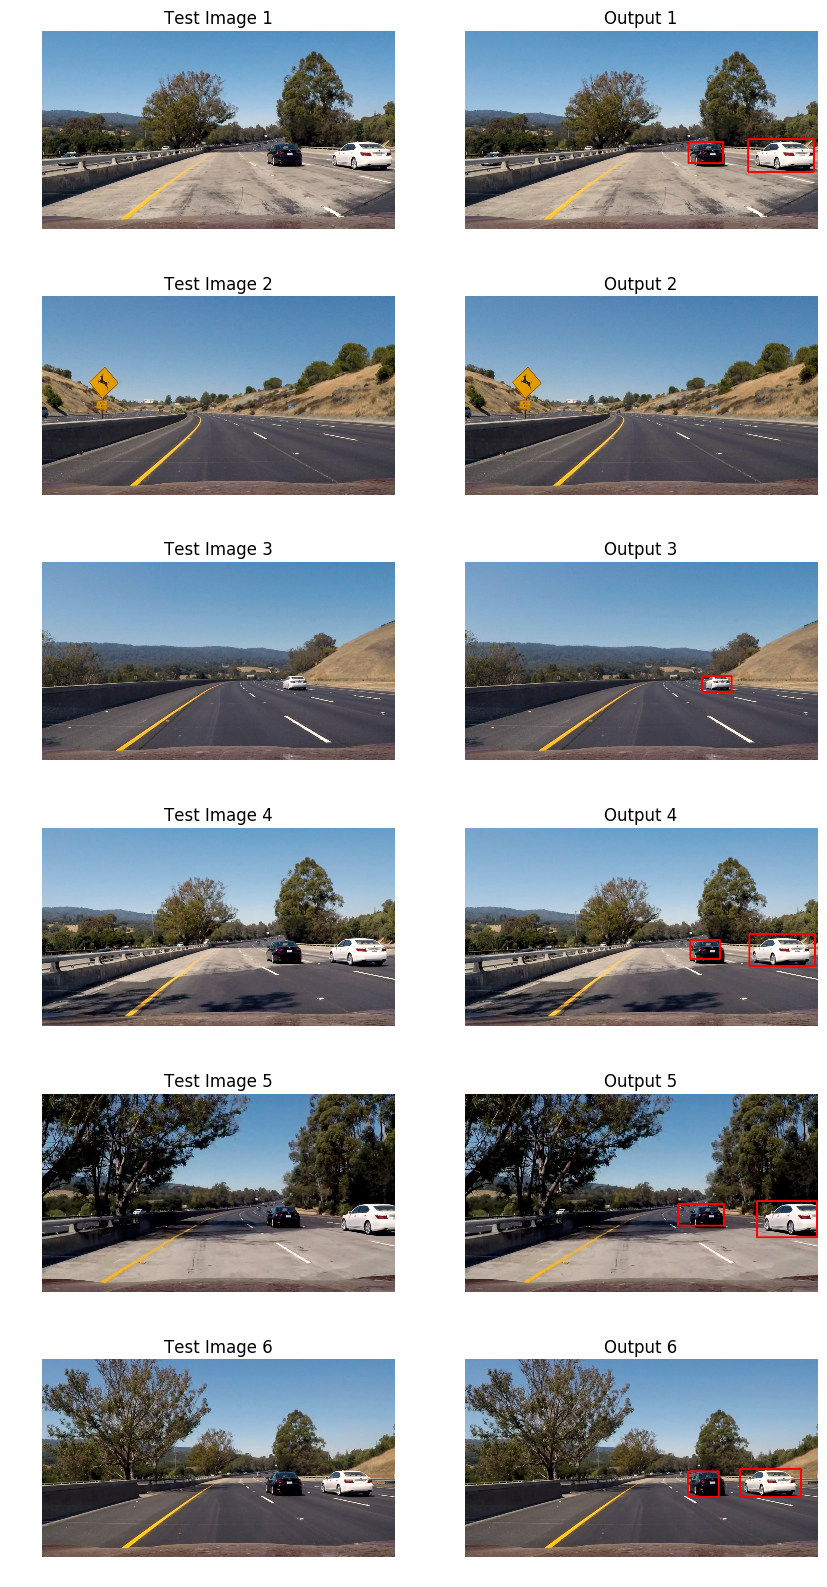

In [ ]:
filenames = glob.glob("test_images/*.jpg")
num_files = len(filenames)

plt.rcParams['figure.figsize'] = (10, 20)

for i in range(num_files):
    image = mpimg.imread(filenames[i])
    final = pipeline(image)
    mpimg.imsave("output_images/test%d.jpg" % (i+1), final)
    
    plt.subplot(num_files,2,i*2+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Test Image %d" % (i+1))
    plt.subplot(num_files,2,i*2+2)
    plt.imshow(final)
    plt.axis('off')
    plt.title("Output %d" % (i+1))

In [ ]:
# Apply it on a video
from moviepy.editor import VideoFileClip

project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("Part 4 Video.mp4")
lane_clip = clip1.fl_image(pipeline)
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [1:11:36<00:01,  1.67s/it]  | 1/1261 [00:01<38:38,  1.84s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1h 55min 26s, sys: 3min 57s, total: 1h 59min 23s
Wall time: 1h 11min 38s


## Conclusion

We see that after preprocessing and normalization, we build our model which is able to create bounded box.

We took reference of various models and took help of some test images to test our model on images first as well.

Also, for videos, we used VideoFileClip from moviepy.editor and it was reasonably good in creation of bounded boxes. 